In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import sys
import numpy as np
import tensorflow as tf
from learnMSA import msa_hmm
from matplotlib import pyplot as plt

In [2]:
def run_tests(runner_func, name, datasets=["homfam", "balifam10000"]):
    stdout = sys.stdout
    for dataset in datasets:
        result_file = "test_results/"+name+"_results."+dataset+".txt"
        if os.path.exists(result_file):
            continue 
        sys.stdout = open("test_results/"+name+"."+dataset+".log", "a")
        with open(result_file, "a") as results_file:
            for file in os.listdir("../MSA-HMM-Analysis/data/"+dataset+"/train"):
                if file.endswith(".fasta"):
                    family = ".".join(file.split(".")[:-1])
                    train_filename = "../MSA-HMM-Analysis/data/"+dataset+"/train/" + file
                    ref_filename = "../MSA-HMM-Analysis/data/"+dataset+"/refs/" + family + ".ref"
                    best_alignment, r = runner_func(train_filename, ref_filename)
                    results_file.write(family + " " + str(r) + "\n")
                    results_file.flush()
        sys.stdout.close()
    sys.stdout = stdout

def check_results(filepath, scale=1.):
    with open(filepath, "r") as file:
        scores = {line.strip().split(" ")[0] : float(line.strip().split(" ")[1])*scale for line in file if len(line.strip()) > 0}
        return scores
    
def compare_results(scores, ref_scores):
    mean_score =  np.mean(list(scores.values()))
    mean_ref_score = np.mean(list(ref_scores.values()))
    print("scores mean:", mean_score, "ref_scores mean:", mean_ref_score)
    diffs = [(s-ref_scores[f], f) for f,s in scores.items()]
    diffs.sort()
    diffs = [(f,np.round(s, 3)) for s,f in diffs]
    print(diffs[:5], "...", diffs[-5:])

def compare_to_ref(name, 
                   datasets=["homfam", "balifam10000"],
                   scale=100):
    for dataset in datasets:
        print(dataset)
        compare_results(check_results("test_results/"+name+"_results."+dataset+".txt", scale=scale), 
                        check_results(r"../MSA-HMM-Analysis/results/msa_hmm2/msa_hmm2."+dataset+".out"))

def compare_to_baseline(name, 
                   datasets=["homfam", "balifam10000"],
                   scale=100):
    for dataset in datasets:
        print(dataset)
        compare_results(check_results("test_results/"+name+"_results."+dataset+".txt", scale=scale), 
                        check_results("test_results/baseline_results."+dataset+".txt", scale=scale))

### Baseline 
Test the new AncProbsLayer with settings resembling learnMSA's default behavior. The only real difference to the original learnMSA is that tau is no longer hard constrained but now passed through a softplus. Usually this should not make a large difference, however, before it was possible for the gradients to vanish if tau_kernel < 0.

In [3]:
def run_learnMSA_baseline(train_filename, ref_filename, num_runs = 3):
    config = dict(msa_hmm.config.default)
    out_filename = "../MSA-HMM-Analysis/results/learnMSA_new/alignments/" + train_filename.split("/")[-1].split(".")[0] + ".projection.fasta"
    return msa_hmm.align.run_learnMSA(num_runs, 
                                      train_filename,
                                      out_filename,
                                      config, 
                                      ref_filename=ref_filename, 
                                      verbose=True)

In [6]:
run_tests(run_learnMSA_baseline, "baseline")

In [7]:
#make sure that baseline reproduces the results of the original learnMSA
compare_to_ref("baseline")

homfam
scores mean: 79.64971567684702 ref_scores mean: 80.26063829787235
[('rvp', -35.55), ('phc', -32.303), ('gluts', -15.405), ('rhv', -9.027), ('seatoxin', -8.067)] ... [('tgfb', 5.597), ('cyt3', 5.665), ('DEATH', 6.085), ('peroxidase', 10.574), ('cryst', 11.229)]
balifam10000
scores mean: 75.48473565061919 ref_scores mean: 75.71666666666665
[('PF00625.10000', -11.714), ('PF02878.10000', -8.09), ('PF04082.10000', -7.233), ('PF01814.10000', -2.922), ('PF00202.10000', -2.785)] ... [('PF07654.10000', 2.629), ('PF02836.10000', 3.295), ('PF00037.10000', 3.791), ('PF13393.10000', 6.403), ('PF14604.10000', 6.496)]


### Baseline but keep tau in model surgery

In [13]:
def extract_encoder_weights(encoder_model, pos_expand, expansion_lens, pos_discard):
    """ A simple callback that can be passed to learnMSA via the config to extract the parameters 
        of the AncProbsLayer after each iteration of model surgery and pass them to the next model.
        The default behavior without the extractor is that the weights are re-initialized each time.
    """
    i = [l.name for l in encoder_model.layers].index("AncProbsLayer")
    anc_probs_layer = encoder_model.layers[i]
    return [tf.constant_initializer(w.numpy()) for w in anc_probs_layer.weights]

def run_learnMSA_baseline_keep_tau(train_filename, ref_filename, num_runs = 3):  
    config = dict(msa_hmm.config.default)
    config["encoder_weight_extractor"] = extract_encoder_weights
    out_filename = "../MSA-HMM-Analysis/results/learnMSA_new/alignments/" + train_filename.split("/")[-1].split(".")[0] + ".projection.fasta"
    return msa_hmm.align.run_learnMSA(num_runs, 
                                      train_filename,
                                      out_filename,
                                      config, 
                                      ref_filename=ref_filename, 
                                      verbose=True)

In [15]:
run_tests(run_learnMSA_baseline_keep_tau, "baseline_keep_tau", datasets=["homfam"])

In [16]:
compare_to_baseline("baseline_keep_tau")

homfam
scores mean: 79.70448354759833 ref_scores mean: 79.64971567684702
[('gluts', -24.484), ('peroxidase', -17.161), ('cryst', -12.292), ('Rhodanese', -6.67), ('TNF', -5.827)] ... [('blmb', 5.932), ('HMG_box', 9.065), ('oxidored_q6', 15.853), ('rvp', 32.882), ('phc', 38.228)]
balifam10000
scores mean: 74.89694429133138 ref_scores mean: 75.48473565061919
[('PF13393.10000', -14.226), ('PF07679.10000', -8.942), ('PF13561.10000', -7.539), ('PF13365.10000', -6.671), ('PF00037.10000', -6.34)] ... [('PF00018.10000', 2.465), ('PF00625.10000', 3.149), ('PF00078.10000', 3.348), ('PF04082.10000', 9.732), ('PF02878.10000', 10.861)]


### Experiment 1: Constant sites

As shown with learnMSA 1.0, alignment accuracy can be increased, if the fixed one-hot encoding of sites is replaced by the expected amino acid distribution after a short evolutionary time under a substitution model. The evolutionary time is learned jointly with the HMM.

However, the substitution rate varies among sites. Some sites (~18% in the alignments used to train the LG rate matrix) are even constant. Those may be in conflict with highly diverse sites when using a single fixed rate matrix and a global evolutionary time for the whole sequence. 

As a solution, we train an extended pHMM that learns an additional Bernoulli distribution per match state that is used to choose between the regular rate matrix used by learnMSA and a matrix of zeros for constant sites. 

$P(S \mid M) = \sum_{k=1}^M p_k Anc(S, Q_k) \cdot P_M$

with

$Anc(S, Q_k) = S \cdot expm(\tau_S Q_k)$

($S$ is a sequence position and $M$ an match state. Left away indices for simplicity.)

In [24]:
def reduce_multinomial_emissions(B, inputs):
    """ Emission function that models a random experiment where one of 
        m rate matrices is selected under a learned multinomial distribution per match state. 
        Args:
            B: List of 2 emission matricies with shapes [(q, s+1), (q, m+1)]
            inputs: Stacked ancestral probabilities. Shape: (b, m*(s+1))
    """
    s = tf.shape(B[0])[-1]
    m = tf.shape(B[1])[-1]-1
    inputs = tf.reshape(inputs, (tf.shape(inputs)[0], m, s))
    # reduce the alphabet dimension first for memory efficiency
    emission_prob = tf.einsum("qs,bms->bqm", B[0], inputs)
    multinomial = B[1][:,:-1]
    multinomial_emission_prob = tf.einsum("bqm,qm->bq", emission_prob, multinomial)
    terminal_emissions = tf.expand_dims(B[1][:,-1], 0) 
    terminal_inputs = inputs[:,:1,-1] 
    terminal_posterior = terminal_inputs * terminal_emissions
    multinomial_emission_prob += terminal_posterior
    return multinomial_emission_prob

class SimpleDirichletPrior():
    def __init__(self, alpha):
        self.alpha = alpha
        
    def __call__(self, B):
        model_length = int((tf.shape(B)[0]-2)/2)
        B = B[1:model_length+1,:-1]
        prior = tf.math.log(B)
        prior = tf.reduce_sum(self.alpha * prior, -1)
        return prior

def constant_sites_model_generator(num_seq,
                            effective_num_seq,
                            model_length, 
                            config,
                            alphabet_size=25):
    anc_probs_layer = AncProbsLayer(num_seq,
                                    2,
                                    frequencies=config["background_distribution"],
                                    rate_init=config["encoder_initializer"][0],
                                    exchangeability_init=config["encoder_initializer"][1],
                                    trainable_exchangeabilities=config["trainable_exchangeabilities"])
    return generic_model_generator(anc_probs_layer, 
                                    num_seq,
                                    effective_num_seq,
                                    model_length, 
                                    config,
                                    alphabet_size)

def run_learnMSA_constant_sites(train_filename, ref_filename, num_runs = 3):
    epsilon=1e-32
    R, p = parse_paml(paml_lines, msa_hmm.fasta.alphabet[:-1])
    exchangeability_init = np.concatenate([R, 
                                           np.zeros_like(R)], axis=0)
    exchangeability_init = inverse_softplus(exchangeability_init + epsilon)

    config = dict(msa_hmm.config.default)
    c = 0. #increase c to shift to increase p_0
    config["emission_init"] = [msa_hmm.config.make_default_emission_init(), 
                               msa_hmm.config.EmissionInitializer(np.array([c, -c]))]
    config["insertion_init"] = [msa_hmm.config.make_default_insertion_init(), 
                                                tf.constant_initializer([c, -c])]
    config["trainable_exchangeabilities"] = False
    config["encoder_initializer"] = [tf.constant_initializer(-3), 
                                     tf.constant_initializer(exchangeability_init)]
    config["background_distribution"] = p
    #config["encoder_weight_extractor"] = extract_encoder_weights
    config["kernel_dim"] = [25, 2]
    config["emission_func"] = reduce_multinomial_emissions
    config["emission_matrix_generator"] = [msa_hmm.cell.make_default_emission_matrix]*2
    config["emission_prior"] = [msa_hmm.cell.AminoAcidPrior(), 
                                # use a prior that strongly favors p_LG = 1 and p_constant = 0
                                SimpleDirichletPrior(alpha = np.array([[180.0, 0.]]))]
    return run_learnMSA(train_filename, 
                        ref_filename, 
                        constant_sites_model_generator,
                        config, 
                        num_runs)

Training of 1 independent models on file egf.fasta
Configuration:
transition_init : {'begin_to_match': <learnMSA.msa_hmm.Configuration.EntryInitializer object at 0x7fbefc073070>, 'match_to_end': <learnMSA.msa_hmm.Configuration.ExitInitializer object at 0x7fbefc073b50>, 'match_to_match': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7fbefc0838e0>, 'match_to_insert': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7fbefc083b80>, 'insert_to_match': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fbefc083160>, 'insert_to_insert': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fbefc083910>, 'match_to_delete': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7fbefc083ac0>, 'delete_to_match': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fbefc0832b0>, 'delete_to_delete': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fbefc083f70>, 'left_flank_loop': <tensorflow.python.ops.init_ops_v2.

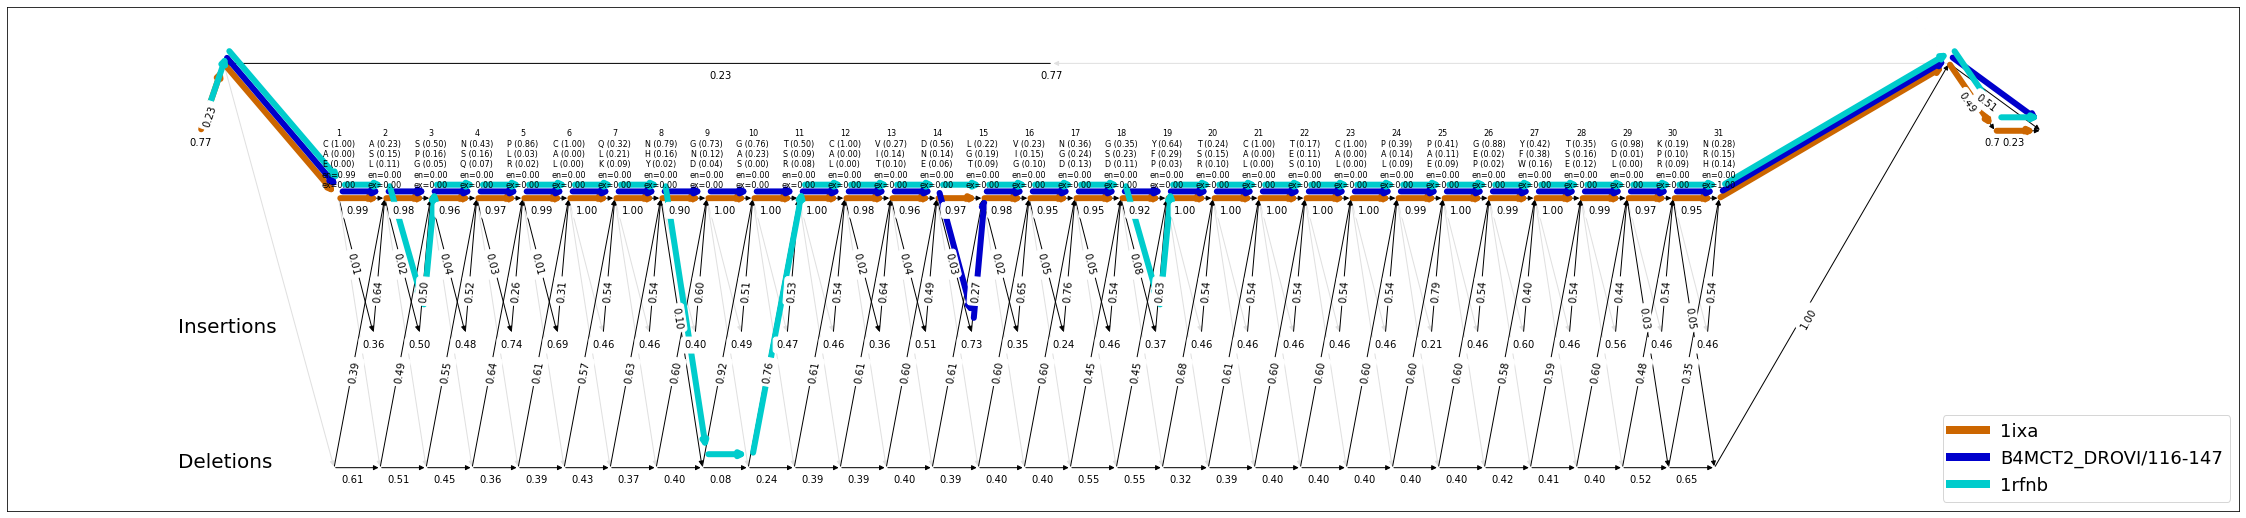

In [25]:
f = "egf"
d = "homfam"
train_filename = "../MSA-HMM-Analysis/data/"+d+"/train/"+f+".fasta"
ref_filename = "../MSA-HMM-Analysis/data/"+d+"/refs/"+f+".ref"
best_alignment, r = run_learnMSA_constant_sites(train_filename, ref_filename, num_runs=1)

# print the alignment
max_seq = 20
msa = best_alignment.to_string()
for s in msa[:max_seq]:
    print(s)
if len(msa) > max_seq:
    print(len(msa) - max_seq, "sequences omitted.")
    
#plot the model
fig = plt.figure(frameon=False)
ax = fig.add_axes([0, 0, 1, 1])
msa_hmm.vis.plot_hmm(best_alignment, ax, 
         seq_indices=[best_alignment.indices[0], 11, best_alignment.indices[-1]],
         path_colors=["#CC6600", "#0000cc", "#00cccc"])  

As seen in the cell below, when using a strict prior for the multinomials, learnMSA correctly finds the conserved cysteines in the EGF family and applies the constant rate matrix, while it relies on LG for the rest of the sequence.

*The same effect could be modeled with a single rate matrix and a learnable evolutionary time per match state.*

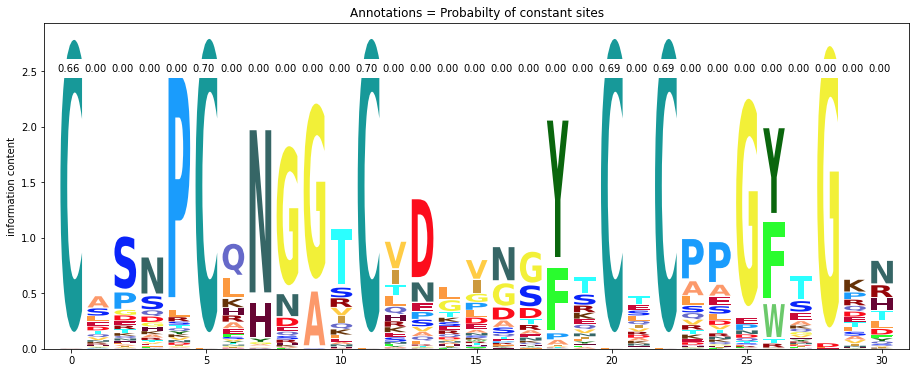

In [31]:
fig, ax = plt.subplots()
msa_hmm.vis.make_logo(best_alignment, ax)
B = best_alignment.msa_hmm_layer.cell.make_B()
model_len = best_alignment.msa_hmm_layer.cell.length
for i,p in enumerate(B[1][1:1+model_len,1]):
    plt.annotate("%.2f" % p, (i-0.5, 2.5), backgroundcolor="w")
plt.title("Annotations = Probabilty of constant sites");

In [32]:
run_tests(run_learnMSA_constant_sites, "constant_sites")

In [33]:
compare_to_baseline("constant_sites")

homfam
scores mean: 79.48140069873058 ref_scores mean: 79.64971567684702
[('tRNA-synt_2b', -21.785), ('adh', -14.121), ('peroxidase', -9.032), ('Ald_Xan_dh_2', -5.886), ('lyase_1', -5.728)] ... [('rhv', 4.896), ('oxidored_q6', 5.969), ('HMG_box', 9.065), ('gluts', 18.347), ('phc', 25.598)]
balifam10000
scores mean: 76.69680077147422 ref_scores mean: 75.48473565061919
[('PF00078.10000', -5.58), ('PF00505.10000', -4.469), ('PF02836.10000', -4.175), ('PF07654.10000', -2.449), ('PF01814.10000', -1.567)] ... [('PF00625.10000', 5.41), ('PF13378.10000', 5.7), ('PF02878.10000', 7.285), ('PF13365.10000', 9.843), ('PF04082.10000', 10.563)]


Constant sites improve accuracy on balifam.

### Experiment 2: Learn a family specific rate matrix.

Like the baseline but with the symmetric part $R$ of the rate matrix made trainable. This trains a rate matrix for the specific purpose of maximizing the pHMM MAP estimate. However, such a matrix is not necessarily biologically plausible. Learning only the symmetric part at least prevents a rate matrix that mutates all sequences to a single amino acid and trivially aligns these skewed sequences as trivial linear chains. 

In [34]:
def run_learnMSA_family_rate(train_filename, ref_filename, num_runs = 3):
    epsilon=1e-32
    R, p = parse_paml(paml_lines, msa_hmm.fasta.alphabet[:-1])
    exchangeability_init = inverse_softplus(R + epsilon)

    config = dict(msa_hmm.config.default)
    config["trainable_exchangeabilities"] = True #the only change compared to baseline
    config["encoder_initializer"] = [tf.constant_initializer(-3), 
                                     tf.constant_initializer(exchangeability_init)]
    config["background_distribution"] = p
    return run_learnMSA(train_filename, 
                        ref_filename, 
                        baseline_model_generator,
                        config, 
                        num_runs)

Training of 1 independent models on file egf.fasta
Configuration:
transition_init : {'begin_to_match': <learnMSA.msa_hmm.Configuration.EntryInitializer object at 0x7fbefc073070>, 'match_to_end': <learnMSA.msa_hmm.Configuration.ExitInitializer object at 0x7fbefc073b50>, 'match_to_match': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7fbefc0838e0>, 'match_to_insert': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7fbefc083b80>, 'insert_to_match': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fbefc083160>, 'insert_to_insert': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fbefc083910>, 'match_to_delete': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7fbefc083ac0>, 'delete_to_match': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fbefc0832b0>, 'delete_to_delete': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fbefc083f70>, 'left_flank_loop': <tensorflow.python.ops.init_ops_v2.

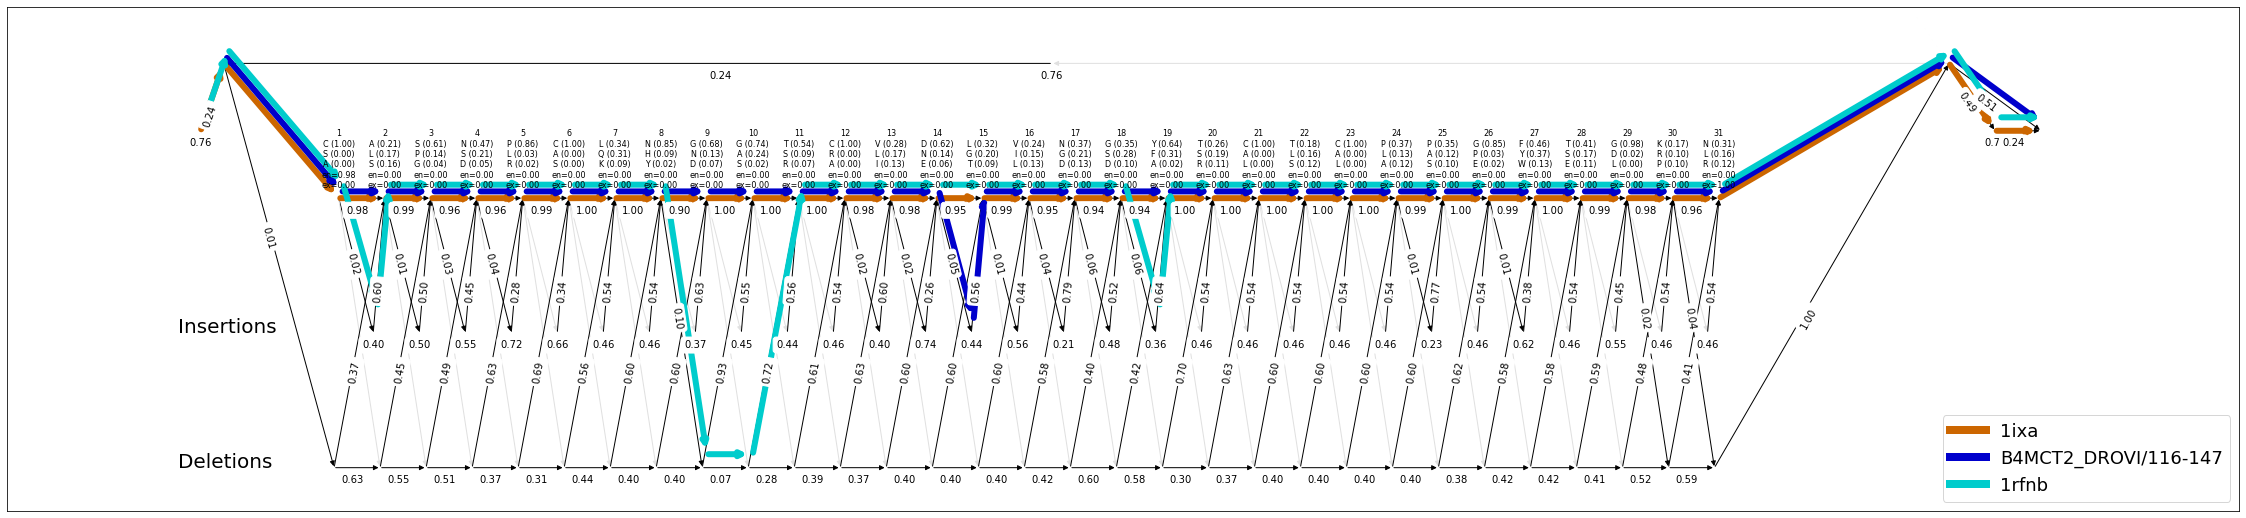

In [35]:
f = "egf"
d = "homfam"
train_filename = "../MSA-HMM-Analysis/data/"+d+"/train/"+f+".fasta"
ref_filename = "../MSA-HMM-Analysis/data/"+d+"/refs/"+f+".ref"
best_alignment, r = run_learnMSA_family_rate(train_filename, ref_filename, num_runs=1)

# print the alignment
max_seq = 20
msa = best_alignment.to_string()
for s in msa[:max_seq]:
    print(s)
if len(msa) > max_seq:
    print(len(msa) - max_seq, "sequences omitted.")
    
#plot the model
fig = plt.figure(frameon=False)
ax = fig.add_axes([0, 0, 1, 1])
msa_hmm.vis.plot_hmm(best_alignment, ax, 
         seq_indices=[best_alignment.indices[0], 11, best_alignment.indices[-1]],
         path_colors=["#CC6600", "#0000cc", "#00cccc"])  

In [38]:
anc_probs_layer = best_alignment.encoder_model.layers[-4] 
with np.printoptions(precision=3, linewidth=100000, suppress=True):
    print("tau:\n", anc_probs_layer.make_tau(best_alignment.indices))
    print("frequencies:\n", anc_probs_layer.frequencies[:-1])
    print("learned R:\n", anc_probs_layer.make_R(anc_probs_layer.exchangeability_kernel).numpy())
    print("initial R:\n", anc_probs_layer.make_R(anc_probs_layer.exchangeability_init([1,20,20])).numpy())

tau:
 tf.Tensor([0.175 0.192 0.713 1.02  0.862 0.951 0.458 0.843 1.049 0.033 1.007 1.225], shape=(12,), dtype=float32)
frequencies:
 tf.Tensor([0.079 0.056 0.042 0.053 0.013 0.041 0.072 0.057 0.022 0.062 0.099 0.065 0.023 0.042 0.044 0.061 0.053 0.012 0.034], shape=(19,), dtype=float32)
learned R:
 [[[ 0.     0.027  0.002  0.008  0.012  0.016  0.014  0.011  0.107  0.019  0.006  0.01   0.736  0.016  0.016  0.065  0.01   0.173  0.002  0.041]
  [ 0.027  0.     0.009  0.276  0.003  0.025  0.01   0.039  0.29   0.006  3.     0.136  0.059  0.003  0.004  0.472  0.025  0.051  0.052  0.651]
  [ 0.002  0.009  0.     0.024  0.004  0.226  0.004  0.174 18.017  0.002  0.     0.099  0.019  0.004  0.054  0.746  0.01   0.008  0.019  0.   ]
  [ 0.008  0.276  0.024  0.     0.     2.994  1.366  0.053  0.187  0.001  0.004  0.224  0.076  0.     0.015  4.077  0.339  0.016  0.001  0.009]
  [ 0.012  0.003  0.004  0.     0.     0.001  0.     0.004  0.004  0.002  0.004  0.     0.005  0.006  0.004  0.019  0.007  0

In [39]:
" ".join([str(x) for x in enumerate(msa_hmm.fasta.alphabet)])

"(0, 'A') (1, 'R') (2, 'N') (3, 'D') (4, 'C') (5, 'Q') (6, 'E') (7, 'G') (8, 'H') (9, 'I') (10, 'L') (11, 'K') (12, 'M') (13, 'F') (14, 'P') (15, 'S') (16, 'T') (17, 'W') (18, 'Y') (19, 'V') (20, 'B') (21, 'Z') (22, 'X') (23, 'U') (24, 'O') (25, '$')"

In [40]:
run_tests(run_learnMSA_family_rate, "family_rate", datasets=["homfam"])

In [41]:
compare_to_baseline("family_rate")

homfam
scores mean: 79.65043422345252 ref_scores mean: 79.64971567684702
[('gluts', -28.363), ('Acetyltransf', -12.951), ('tgfb', -10.127), ('peroxidase', -6.645), ('TNF', -6.619)] ... [('toxin', 6.767), ('HMG_box', 9.065), ('seatoxin', 10.88), ('adh', 13.128), ('phc', 30.811)]
balifam10000
scores mean: 75.17328779311786 ref_scores mean: 75.48473565061919
[('PF00150.10000', -25.654), ('PF04082.10000', -9.363), ('PF00037.10000', -5.859), ('PF13393.10000', -4.584), ('PF00505.10000', -2.711)] ... [('PF00202.10000', 3.718), ('PF13365.10000', 4.314), ('PF00078.10000', 5.62), ('PF00625.10000', 10.258), ('PF02878.10000', 11.126)]


### Experiment 3: Like experiment 1 but trainable rate matrices [not working]

In [83]:
def extract_encoder_weights_no_tau(encoder_model, pos_expand, expansion_lens, pos_discard):
    i = [l.name for l in encoder_model.layers].index("AncProbsLayer")
    anc_probs_layer = encoder_model.layers[i]
    return [tf.constant_initializer(-3), 
            tf.constant_initializer(anc_probs_layer.weights[1].numpy())]

def trainable_matrix_pair_model_generator(num_seq,
                            effective_num_seq,
                            model_length, 
                            config,
                            alphabet_size=25):
    anc_probs_layer = AncProbsLayer(num_seq,
                                    2,
                                    frequencies=config["background_distribution"],
                                    rate_init=config["encoder_initializer"][0],
                                    exchangeability_init=config["encoder_initializer"][1],
                                    trainable_exchangeabilities=config["trainable_exchangeabilities"])
    return generic_model_generator(anc_probs_layer, 
                                    num_seq,
                                    effective_num_seq,
                                    model_length, 
                                    config,
                                    alphabet_size)

def run_learnMSA_trainable_matrix_pair(train_filename, ref_filename, num_runs = 3):
    epsilon=1e-32
    R, p = parse_paml(paml_lines, msa_hmm.fasta.alphabet[:-1])
    exchangeability_init = np.concatenate([R, 
                                           np.zeros_like(R)], axis=0)
    exchangeability_init = inverse_softplus(exchangeability_init + epsilon)

    config = dict(msa_hmm.config.default)
    c = 0. #increase c to shift to increase p_0
    config["emission_init"] = [msa_hmm.config.make_default_emission_init(), 
                               msa_hmm.config.EmissionInitializer(np.array([c, -c]))]
    config["insertion_init"] = [msa_hmm.config.make_default_insertion_init(), 
                                                tf.constant_initializer([c, -c])]
    config["trainable_exchangeabilities"] = True
    config["encoder_initializer"] = [tf.constant_initializer(-3), 
                                     tf.constant_initializer(exchangeability_init)]
    config["background_distribution"] = p
    config["encoder_weight_extractor"] = extract_encoder_weights_no_tau
    config["kernel_dim"] = [25, 2]
    config["emission_func"] = reduce_multinomial_emissions
    config["emission_matrix_generator"] = [msa_hmm.cell.make_default_emission_matrix]*2
    config["emission_prior"] = [msa_hmm.cell.AminoAcidPrior(), 
                                # use a prior that strongly favors p_LG = 1 and p_constant = 0
                                SimpleDirichletPrior(alpha = np.array([[180.0, 0.]]))]
    return run_learnMSA(train_filename, 
                        ref_filename, 
                        trainable_matrix_pair_model_generator,
                        config, 
                        num_runs)

In [ ]:
f = "egf"
d = "homfam"
train_filename = "../MSA-HMM-Analysis/data/"+d+"/train/"+f+".fasta"
ref_filename = "../MSA-HMM-Analysis/data/"+d+"/refs/"+f+".ref"
best_alignment, r = run_learnMSA_trainable_matrix_pair(train_filename, ref_filename, num_runs=1)

# print the alignment
max_seq = 20
msa = best_alignment.to_string()
for s in msa[:max_seq]:
    print(s)
if len(msa) > max_seq:
    print(len(msa) - max_seq, "sequences omitted.")
    
#plot the model
fig = plt.figure(frameon=False)
ax = fig.add_axes([0, 0, 1, 1])
msa_hmm.vis.plot_hmm(best_alignment, ax, 
         seq_indices=[best_alignment.indices[0], 11, best_alignment.indices[-1]],
         path_colors=["#CC6600", "#0000cc", "#00cccc"])  

In [ ]:
anc_probs_layer = best_alignment.encoder_model.layers[-4] 
with np.printoptions(precision=3, linewidth=100000, suppress=True):
    print("tau:\n", anc_probs_layer.make_tau(best_alignment.indices))
    print("frequencies:\n", anc_probs_layer.frequencies[:-1])
    print("learned R_1:\n", anc_probs_layer.make_R(anc_probs_layer.exchangeability_kernel).numpy()[0,:20, :20])
    print("learned R_2:\n", anc_probs_layer.make_R(anc_probs_layer.exchangeability_kernel).numpy()[1,:20, :20])

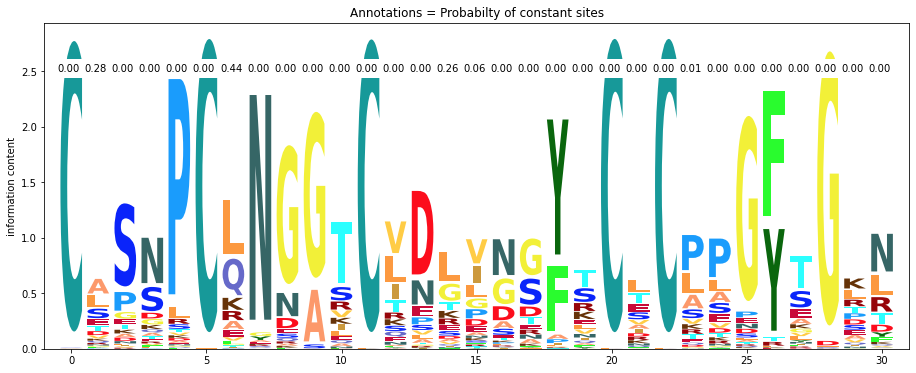

In [52]:
fig, ax = plt.subplots()
msa_hmm.vis.make_logo(best_alignment, ax)
B = best_alignment.msa_hmm_layer.cell.make_B()
model_len = best_alignment.msa_hmm_layer.cell.length
for i,p in enumerate(B[1][1:1+model_len,1]):
    plt.annotate("%.2f" % p, (i-0.5, 2.5), backgroundcolor="w")
plt.title("Annotations = Probabilty of constant sites");

### Experiment 4: Family specific rate matrix and keep it across model surgery iterations

In [84]:
def run_learnMSA_keep_family_rate(train_filename, ref_filename, num_runs = 3):
    epsilon=1e-32
    R, p = parse_paml(paml_lines, msa_hmm.fasta.alphabet[:-1])
    exchangeability_init = inverse_softplus(R + epsilon)

    config = dict(msa_hmm.config.default)
    config["trainable_exchangeabilities"] = True 
    config["encoder_initializer"] = [tf.constant_initializer(-3), 
                                     tf.constant_initializer(exchangeability_init)]
    config["background_distribution"] = p
    #config["encoder_weight_extractor"] = extract_encoder_weights_no_tau
    return run_learnMSA(train_filename, 
                        ref_filename, 
                        config, 
                        baseline_model_generator,
                        num_runs)

Training of 1 independent models on file egf.fasta
Configuration:
transition_init : {'begin_to_match': <learnMSA.msa_hmm.Configuration.EntryInitializer object at 0x7f770198fdf0>, 'match_to_end': <learnMSA.msa_hmm.Configuration.ExitInitializer object at 0x7f770198f820>, 'match_to_match': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7f770198fb80>, 'match_to_insert': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7f76f04cd6d0>, 'insert_to_match': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7f76f04cd910>, 'insert_to_insert': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7f76f04cdf70>, 'match_to_delete': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7f76f04cd6a0>, 'delete_to_match': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7f76f04cd160>, 'delete_to_delete': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7f76f04cd280>, 'left_flank_loop': <tensorflow.python.ops.init_ops_v2.

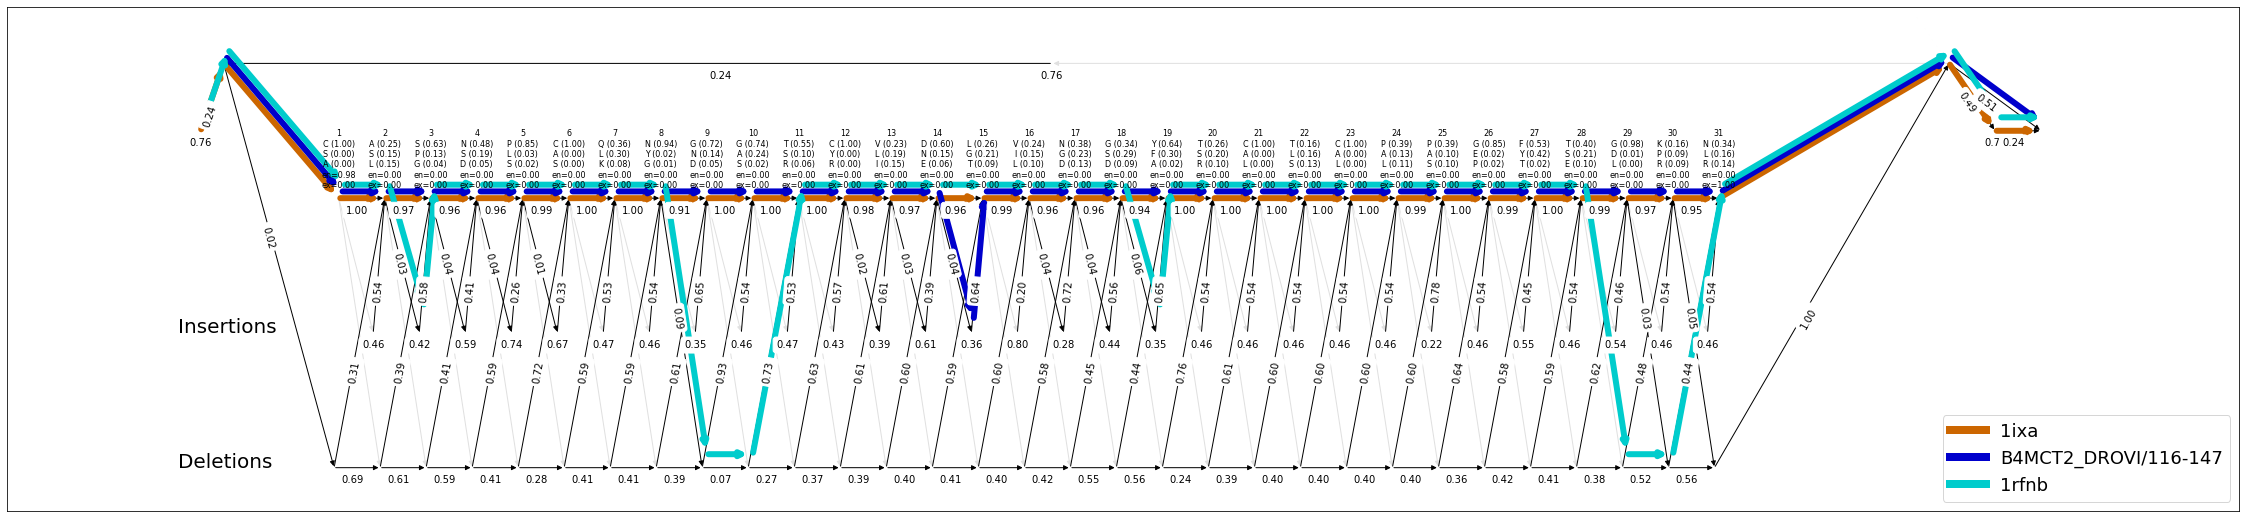

In [61]:
f = "egf"
d = "homfam"
train_filename = "../MSA-HMM-Analysis/data/"+d+"/train/"+f+".fasta"
ref_filename = "../MSA-HMM-Analysis/data/"+d+"/refs/"+f+".ref"
best_alignment, r = run_learnMSA_trainable_matrix_pair(train_filename, ref_filename, num_runs=1)

# print the alignment
max_seq = 20
msa = best_alignment.to_string()
for s in msa[:max_seq]:
    print(s)
if len(msa) > max_seq:
    print(len(msa) - max_seq, "sequences omitted.")
    
#plot the model
fig = plt.figure(frameon=False)
ax = fig.add_axes([0, 0, 1, 1])
msa_hmm.vis.plot_hmm(best_alignment, ax, 
         seq_indices=[best_alignment.indices[0], 11, best_alignment.indices[-1]],
         path_colors=["#CC6600", "#0000cc", "#00cccc"])  

In [ ]:
run_tests(run_learnMSA_family_rate, "family_rate", datasets=["homfam"])

In [ ]:
compare_to_ref("family_rate")

### Experiment 5: Train a local mutation rate per match state

$P(S \mid M_i) = Anc(S, \tau_{i} Q ) \cdot P_{M_i}$

with (as before)

$Anc(S, Q) = S^T \cdot expm(\tau_S Q)$

This could be a more flexible solution than Experiment 1 since any type of fast- or slowly-evolving position can be modeled under a shared substitution matrix.

**The direct approach with m * l different rate matricies (each product of sequence- and match-state-rate yields a unique matrix) is computationally intensive.** An indirect approach is more efficient and has probably the same effect:

Set a number of rate classes $c<l$ and soft-select from the $c$ rate matrices with a learned multinomial distribution per match. 

Also train an insertion specific rate or keep it constant?

In [42]:
num_rate_classes = 10

#currently unused, memory intensive for long models
def match_rate_emissions(B, inputs):
    """ Emission function that handles a different input for each match state.
        Args:
            B: List of 2 emission matricies with shapes [(q, s+1), (q, k+1)]
            inputs: Stacked ancestral probabilities. Shape: (b, k*s)
    """
    B = B[0]
    model_length = tf.cast((tf.shape(B)[0]-3)/2, tf.int32)
    s = tf.shape(B)[1]
    inputs = tf.reshape(inputs, (-1,model_length+1,s))
    B_part = tf.expand_dims(B[:model_length+1], 0)
    first_insert_and_matches = tf.reduce_sum(B_part * inputs, -1)
    other_inserts = tf.linalg.matvec(B[model_length+1:], inputs[:,0,:])
    return tf.concat([first_insert_and_matches, other_inserts], axis=1)





def constant_sites_model_generator(num_seq,
                            effective_num_seq,
                            model_length, 
                            config,
                            alphabet_size=25):
    anc_probs_layer = AncProbsLayer(num_seq,
                                    2,
                                    frequencies=config["background_distribution"],
                                    rate_init=config["encoder_initializer"][0],
                                    exchangeability_init=config["encoder_initializer"][1],
                                    trainable_exchangeabilities=config["trainable_exchangeabilities"])
    return generic_model_generator(anc_probs_layer, 
                                    num_seq,
                                    effective_num_seq,
                                    model_length, 
                                    config,
                                    alphabet_size)

def run_learnMSA_constant_sites(train_filename, ref_filename, num_runs = 3):
    epsilon=1e-32
    R, p = parse_paml(paml_lines, msa_hmm.fasta.alphabet[:-1])
    exchangeability_init = np.concatenate([R, 
                                           np.zeros_like(R)], axis=0)
    exchangeability_init = inverse_softplus(exchangeability_init + epsilon)

    config = dict(msa_hmm.config.default)
    c = 0. #increase c to shift to increase p_0
    config["emission_init"] = [msa_hmm.config.make_default_emission_init(), 
                               msa_hmm.config.EmissionInitializer(np.array([c, -c]))]
    config["insertion_init"] = [msa_hmm.config.make_default_insertion_init(), 
                                                tf.constant_initializer([c, -c])]
    config["trainable_exchangeabilities"] = False
    config["encoder_initializer"] = [tf.constant_initializer(-3), 
                                     tf.constant_initializer(exchangeability_init)]
    config["background_distribution"] = p
    #config["encoder_weight_extractor"] = extract_encoder_weights
    config["kernel_dim"] = [25, 2]
    config["emission_func"] = reduce_multinomial_emissions
    config["emission_matrix_generator"] = [msa_hmm.cell.make_default_emission_matrix]*2
    config["emission_prior"] = [msa_hmm.cell.AminoAcidPrior(), 
                                # use a prior that strongly favors p_LG = 1 and p_constant = 0
                                SimpleDirichletPrior(alpha = np.array([[180.0, 0.]]))]
    return run_learnMSA(train_filename, 
                        ref_filename, 
                        constant_sites_model_generator,
                        config, 
                        num_runs)




def extract_encoder_weights_positional(encoder_model, pos_expand, expansion_lens, pos_discard):
    i = [l.name for l in encoder_model.layers].index("AncProbsLayer")
    anc_probs_layer = encoder_model.layers[i]
    for w in anc_probs_layer.weights:
        if "tau_kernel" in w.name:
            tau_kernel = w
        elif "exchangeability_kernel" in w.name:
            exchangeability_kernel = w
        elif "matrix_rates_kernel" in w.name:
            matrix_rates_kernel = w
    matrix_rates = msa_hmm.align.apply_mods(matrix_rates_kernel[1:],
                                             pos_expand, 
                                             expansion_lens, 
                                             pos_discard,
                                             inverse_softplus(1.))
    matrix_rates = np.concatenate([matrix_rates_kernel[:1].numpy(), matrix_rates], axis=0)
    anc_probs_layer = encoder_model.layers[i]
    return [tf.constant_initializer(-3), #reset tau
            tf.constant_initializer(exchangeability_kernel.numpy()), 
            tf.constant_initializer(matrix_rates)]

def run_learnMSA_match_rate(train_filename, ref_filename, num_runs = 3):
    epsilon=1e-32
    R, p = parse_paml(paml_lines, msa_hmm.fasta.alphabet[:-1])
    exchangeability_init = inverse_softplus(R + epsilon)
    config = dict(msa_hmm.config.default)
    config["trainable_exchangeabilities"] = False 
    config["encoder_initializer"] = [tf.constant_initializer(-3), 
                                     tf.constant_initializer(exchangeability_init), 
                                     tf.constant_initializer(inverse_softplus(1.))]
    config["background_distribution"] = p
    config["encoder_weight_extractor"] = extract_encoder_weights_positional
    config["emission_func"] = reduce_multinomial_emissions
    config["matrix_rate_l2"] = 1e-1
    
    return run_learnMSA(train_filename, 
                       ref_filename, 
                       match_rate_model_generator,
                       config, 
                       num_runs)

In [43]:
f = "PF00079.10000"
d = "balifam10000"
train_filename = "../MSA-HMM-Analysis/data/"+d+"/train/"+f+".fasta"
ref_filename = "../MSA-HMM-Analysis/data/"+d+"/refs/"+f+".ref"
best_alignment, r = run_learnMSA_match_rate(train_filename, ref_filename, num_runs=1)

# print the alignment
max_seq = 20
msa = best_alignment.to_string()
for s in msa[:max_seq]:
    print(s)
if len(msa) > max_seq:
    print(len(msa) - max_seq, "sequences omitted.")

#plot the model
fig = plt.figure(frameon=False)
ax = fig.add_axes([0, 0, 1, 1])
msa_hmm.vis.plot_hmm(best_alignment, ax, 
         seq_indices=[best_alignment.indices[0], 11, best_alignment.indices[-1]],
         path_colors=["#CC6600", "#0000cc", "#00cccc"])  

Training of 1 independent models on file PF00079.10000.fasta
Configuration:
transition_init : {'begin_to_match': <learnMSA.msa_hmm.Configuration.EntryInitializer object at 0x7fbefc073070>, 'match_to_end': <learnMSA.msa_hmm.Configuration.ExitInitializer object at 0x7fbefc073b50>, 'match_to_match': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7fbefc0838e0>, 'match_to_insert': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7fbefc083b80>, 'insert_to_match': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fbefc083160>, 'insert_to_insert': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fbefc083910>, 'match_to_delete': <learnMSA.msa_hmm.Configuration.MatchTransitionInitializer object at 0x7fbefc083ac0>, 'delete_to_match': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fbefc0832b0>, 'delete_to_delete': <tensorflow.python.ops.init_ops_v2.Constant object at 0x7fbefc083f70>, 'left_flank_loop': <tensorflow.python.ops.in

ResourceExhaustedError: OOM when allocating tensor with shape[256,566,581] and type double on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Transpose]

tau= tf.Tensor([0.07070924 0.13788301 0.0107639  ... 0.10376982 0.4457648  0.34639284], shape=(7774,), dtype=float32)
substitution rate at insertions= tf.Tensor(2.7676156, shape=(), dtype=float32)


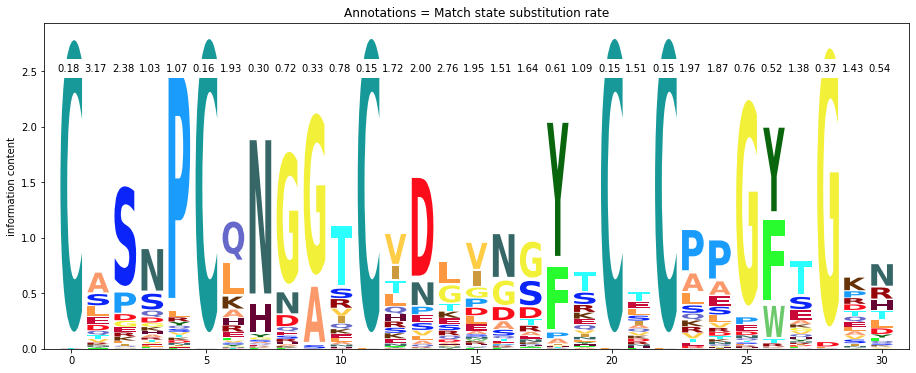

In [155]:
fig, ax = plt.subplots()
msa_hmm.vis.make_logo(best_alignment, ax)
i = [l.name for l in best_alignment.encoder_model.layers].index("AncProbsLayer")
anc_probs_layer = best_alignment.encoder_model.layers[i]
print("tau=", anc_probs_layer.make_tau())
match_rates = anc_probs_layer.make_per_matrix_rate()[1:] 
print("substitution rate at insertions=", anc_probs_layer.make_per_matrix_rate()[0])
for i,p in enumerate(match_rates):
    plt.annotate("%.2f" % p, (i-0.5, 2.5), backgroundcolor="w")
plt.title("Annotations = Match state substitution rate");

In [154]:
anc_probs_layer = best_alignment.encoder_model.layers[-4] 
with np.printoptions(precision=3, linewidth=100000, suppress=True):
    print("tau:\n", anc_probs_layer.make_tau(best_alignment.indices))
    print("frequencies:\n", anc_probs_layer.frequencies[:-1])
    print("learned R:\n", anc_probs_layer.make_R(anc_probs_layer.exchangeability_kernel).numpy()[0,:20, :20])
    print("initial R:\n", anc_probs_layer.make_R(anc_probs_layer.exchangeability_init([1,25,25])).numpy()[0,:20, :20])

tau:
 tf.Tensor([0.109 0.015 0.424 0.378 0.346 0.386 0.341 0.348 0.472 0.104 0.446 0.346], shape=(12,), dtype=float32)
frequencies:
 tf.Tensor([0.079 0.056 0.042 0.053 0.013 0.041 0.072 0.057 0.022 0.062 0.099 0.065 0.023 0.042 0.044 0.061 0.053 0.012 0.034 0.069 0.    0.    0.    0.    0.   ], shape=(25,), dtype=float32)
learned R:
 [[ 0.     0.425  0.277  0.395  2.489  0.97   1.039  2.066  0.359  0.15   0.395  0.537  1.124  0.254  1.178  4.727  2.14   0.181  0.219  2.548]
 [ 0.425  0.     0.752  0.124  0.535  2.808  0.364  0.39   2.427  0.127  0.302  6.326  0.484  0.053  0.333  0.858  0.579  0.594  0.314  0.171]
 [ 0.277  0.752  0.     5.076  0.529  1.696  0.542  1.438  4.509  0.192  0.068  2.145  0.371  0.09   0.162  4.008  2.001  0.045  0.612  0.084]
 [ 0.395  0.124  5.076  0.     0.063  0.523  5.244  0.845  0.927  0.011  0.015  0.283  0.026  0.017  0.394  1.24   0.426  0.03   0.135  0.038]
 [ 2.489  0.535  0.529  0.063  0.     0.085  0.003  0.569  0.641  0.321  0.594  0.013  0.894

In [156]:
run_tests(run_learnMSA_match_rate, "match_rates", datasets=["balifam10000"])

ResourceExhaustedError:  OOM when allocating tensor with shape[544,256,7540] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/model_3/MsaHmmLayer/rnn/TensorArrayUnstack/TensorListStack (defined at /home/jovyan/brain/MSA-HMM/learnMSA/msa_hmm/Training.py:139) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_6825399]

Function call stack:
train_function


In [ ]:
compare_to_baseline("match_rates")

### Experiment 6: Use a (fixed) mixture of 2-3 rate matricies and learn the mixture coefficients

Pretrained mixture models already exist and should be solid (same authors as LG matrix that learnMSA uses). For instance, there is a secondary structure based mixture that was learned with class supervision (extended/helix/other). It would be interesting whether learnMSA can learn mixture coefficients per match state that reflect the real biologic background of this position.

### Experiment 7: Can we incorporate ClaMSA? Train $Q_1, .. , Q_M$?

### Experiment 8: Use a fixed symmetric part $R$ but replace the generic $\pi$ with the distribution from the match state